In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import random
import math
import time
import torch.nn.functional as F

from tqdm.notebook import tqdm
from torch import optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
np.random.seed(1234)
torch.manual_seed(1234)
random.seed(1234)

In [ ]:
def get_padding(in_size, kernel_size, stride):
    if (in_size % stride == 0):
        padding = max(kernel_size - stride, 0)
    else:
        padding = max(kernel_size - (in_size % stride), 0)
    return (padding)    

In [ ]:
class Flatten(nn.Module):
   def forward(self, src):
     return torch.flatten(src)


In [ ]:
def get_feature_extractor_1(input_size):
  #layers = []
  pad = get_padding(input_size, 50, 6)
  conv1 = nn.Conv2d(1, 64, kernel_size = (50, 1), stride=(6, 1), padding= (pad, 0))
  relu1 = nn.ReLU()
  pad = get_padding(input_size, 8,  8)
  pool1 = nn.MaxPool2d(kernel_size = (8, 1), stride=(8, 1), padding=(pad, 0), dilation=1, return_indices=False, ceil_mode=False)
  drop = nn.Dropout(p=0.5, inplace=False)
  conv2 = nn.Conv2d(64, 128, kernel_size = (8, 1), stride=(1, 1), padding='same')
  relu2 = nn.ReLU()
  conv3 = nn.Conv2d(128, 128, kernel_size = (8, 1), stride=(1, 1), padding='same')
  relu3 = nn.ReLU()
  conv4 = nn.Conv2d(128, 128, kernel_size = (8, 1), stride=(1, 1), padding='same')
  relu4 = nn.ReLU()
  pad = get_padding(input_size, 4, 4)
  pool2 = nn.MaxPool2d(kernel_size = (4, 1), stride=(4, 1), padding= (pad, 0), dilation=1, return_indices=False, ceil_mode=False)
  #flat = Flatten()
  return(torch.nn.Sequential(conv1, relu1, pool1, conv2, relu2, conv3, relu3, conv4, relu4, pool2))

In [ ]:
def get_feature_extractor_2(input_size):
  pad = get_padding(input_size, 400,  50)
  conv1 = nn.Conv2d(1, 64, kernel_size = (400, 1), stride=(50, 1), padding=(pad, 0))
  relu1 = nn.ReLU()
  pad = get_padding(input_size, 4, 4)
  pool1 = nn.MaxPool2d(kernel_size = (4, 1), stride=(4, 1), padding=(pad, 0), dilation=1, return_indices=False, ceil_mode=False)
  drop = nn.Dropout(p=0.5, inplace=False)
  conv2 = nn.Conv2d(64, 128, kernel_size = (6, 1), stride=(1, 1), padding='same')
  relu2 = nn.ReLU()
  conv3 = nn.Conv2d(128, 128, kernel_size = (6, 1), stride=(1, 1), padding='same')
  relu3 = nn.ReLU()
  conv4 = nn.Conv2d(128, 128, kernel_size = (6, 1), stride=(1, 1), padding='same')
  relu4 = nn.ReLU()
  pad = get_padding(input_size, 2, 2)
  pool2 = nn.MaxPool2d(kernel_size = (2, 1), stride=(2, 1), padding=(pad, 0), dilation=1, return_indices=False, ceil_mode=False)
  #flat = Flatten()
  return(torch.nn.Sequential(conv1, relu1, pool1, conv2, relu2, conv3, relu3, conv4, relu4, pool2))


In [ ]:
class Encoder(torch.nn.Module): 
    def __init__(self, input_size, hidden_size, dec_hid_dim):
      super().__init__()
      self.feature_extractor1 =  get_feature_extractor_1(input_size)
      self.feature_extractor2 =  get_feature_extractor_2(input_size)
      self.drop = nn.Dropout(p=0.01, inplace=False)
      input_encoder_size = 2944# input_size//8 + input_size//32
      self.rnn = nn.LSTM(input_encoder_size, hidden_size, bidirectional = True, batch_first = True)
      self.n_layers = 1
      self.dec_hid_dim = dec_hid_dim
      self.fc = nn.Linear(hidden_size * 2, dec_hid_dim)
      self.hidden_size = hidden_size

    
    #def init_hidden(self, batch_size=1):
    #    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #    return torch.zeros(self.n_layers, batch_size, self.hidden_size, requires_grad=True).to(device)
    #            torch.zeros(self.n_layers, batch_size, self.hidden_size, requires_grad=True).to(device))    

    def forward(self, src):
      #print("1")
      #src = [batch size, epochs_len, input_size]
      out1 = self.feature_extractor1(src)
      #print(out1.shape)
      out1 = out1.permute(0, 3, 1, 2)
      out1 = torch.flatten(out1, 2, 3)
      #print(out1.shape)
      out2 = self.feature_extractor2(src)
      #print(out2.shape)
      out2 = out2.permute(0, 3, 1, 2)
      out2 = torch.flatten(out2, 2, 3)
      #print(out2.shape)
      #out1 or out2 = [batch size, epochs_len, input_size]

      out = self.drop(torch.cat((out1, out2), axis = 2))
      #print(out.shape)
      #out = [batch size, epochs_len, input_size * 2]
      encoder_outputs, (hidden, c) = self.rnn(out)
      #print(encoder_outputs.shape, hidden.shape, c.shape)
      hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
      #print(hidden.shape)

      return encoder_outputs, hidden #hidden as input for decoder



In [ ]:
 class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        
        #repeat decoder hidden state src_len times
        
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        #encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention= [batch size, src len]
        
        return F.softmax(attention, dim=1)     

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM((enc_hid_dim * 2) + emb_dim, dec_hid_dim, batch_first = True)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        self.n_layers = 1
        self.hidden_size = dec_hid_dim

    def init_hidden(self, batch_size=1):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        return torch.zeros(self.n_layers, batch_size, self.hidden_size, requires_grad=True).to(device)
    #            torch.zeros(self.n_layers, batch_size, self.hidden_size, requires_grad=True).to(device))        
        
    def forward(self, input, hidden_cell, encoder_outputs):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        #batch_size = 128#input.item()
        #print(batch_size)
        #print(input.shape)
       
        #print(encoder_outputs.shape)
        hidden = hidden_cell[0]
        cell = hidden_cell[1]
        input = input.unsqueeze(0)
        #print(hidden.shape)
        #print(cell.shape)
        #input = [1, batch size]
        
        #print(input.shape)
        embedded = self.dropout(self.embedding(input)).permute(1, 0, 2)
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        #encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        ##print(f" weighted.shape = {weighted.shape}")
        #print(f" embedded.shape = {embedded.shape}")
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        #weighted = weighted.permute(1, 0, 2)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
          
        #hidden =  hidden.unsqueeze(0) 
        #print(hidden.shape)
        
        #print(hidden.shape)
        #print(cell.shape)
        #print(hidden.shape)
        hidden = hidden.unsqueeze(0)
        #print(hidden.shape)
        #hidden = [D = 1, batch size, dec hid dim]
        output, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        output = output.permute(1, 0, 2)
        weighted = weighted.permute(1, 0, 2)
        embedded = embedded.permute(1, 0, 2)
        #print(output.shape)
        #print(embedded.shape)
        #print( weighted.shape)
        
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        #print(prediction.shape)
        
        return prediction, (hidden.squeeze(0), cell)    

In [ ]:
class SleepStageClassifier(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.teacher_forcing_ratio = teacher_forcing_ratio
    def forward(self, src, trg, teacher_forcing_ratio):
        #src = [batch size, src len, epoch_len]
        #trg = [batch size, trg len]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        #print(trg)
        #print(f"trg_len{trg_len}")
        trg_vocab_size = self.decoder.output_dim
        #tensor to store decoder outputs
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
        #print(hidden.shape)
        #first input to the decoder is the <sos> tokens
        input = trg[:, 0]
        cell = self.decoder.init_hidden(batch_size)
        stages = []
        #hidden = hidden.unsqueeze(0)
        for t in range(1, trg_len):
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            
            #print(input.shape)
            #print(hidden.shape)
            #print(encoder_outputs.shape)

          
            output, (hidden, cell) = self.decoder(input, (hidden, cell), encoder_outputs)
            #print(f"output_decoder{output.shape}")
            #place predictions in a tensor holding predictions for each token
            outputs[:, t] = output
            #print(output)
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < self.teacher_forcing_ratio
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            stages.append(top1)
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[:, t] if teacher_force else top1
            #print(outputs)
        result = torch.stack(stages, 1)
        return outputs, result  



In [ ]:
INPUT_DIM = 3000
ENC_HID_DIM = 300
DEC_HID_DIM = 300
DEC_EMB_DIM = 7
DEC_DROPOUT = 0.1
OUTPUT_DIM = 7
SOS = 5
EOS = 6
teacher_forcing_ratio = 0.7

In [ ]:
def get_model():
  attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
  enc = Encoder(INPUT_DIM, ENC_HID_DIM, DEC_HID_DIM)
  dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)
  model = SleepStageClassifier(enc, dec, device).to(device)
  return model


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = get_model()

In [ ]:
# def init_weights(m):
#     for name, param in m.named_parameters():
#         if 'weight' in name:
#             nn.init.normal_(param.data, mean=0, std=0.01)
#         else:
#             nn.init.constant_(param.data, 0)
            
# model.apply(init_weights)

def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)

SleepStageClassifier(
  (encoder): Encoder(
    (feature_extractor1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(50, 1), stride=(6, 1), padding=(44, 0))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(8, 1), stride=(8, 1), padding=(0, 0), dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(8, 1), stride=(1, 1), padding=same)
      (4): ReLU()
      (5): Conv2d(128, 128, kernel_size=(8, 1), stride=(1, 1), padding=same)
      (6): ReLU()
      (7): Conv2d(128, 128, kernel_size=(8, 1), stride=(1, 1), padding=same)
      (8): ReLU()
      (9): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=(0, 0), dilation=1, ceil_mode=False)
    )
    (feature_extractor2): Sequential(
      (0): Conv2d(1, 64, kernel_size=(400, 1), stride=(50, 1), padding=(350, 0))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=(0, 0), dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(6, 1), stride=(1, 1), padding=same)
      (4): ReLU(

In [ ]:
class Args:
  def __init__(self): #(data_path, epoch, batch_siz, image_size, learning_rate, weight_deca, learning_rate, learning_rate_gamma, weight_bce, load, output_dir)
    self.data_path = "/content/drive/MyDrive/MADE/semester2/CV/contest02/data/"
    self.epochs = 2
    self.batch_size = 256
    self.lr= 3e-4
    self.weight_decay= 1e-6
    self.learning_rate=None
    self.learning_rate_gamma=None
    self.weight_bce=1
    self.load=None
    self.output_dir="runs/segmentation_baseline"
    self.data_dir ="/content/drive/MyDrive/MADE/Project/train/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/"# "/content/drive/MyDrive/MADE/Project/train/physionet.org/"
args = Args()    

In [ ]:
import os
os.chdir("/content/drive/MyDrive/MADE/Project/train")

In [ ]:
!pip install mne
import mne

     |████████████████████████████████| 6.9 MB 2.8 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from collections import Counter

class EegDataset(Dataset):
    def __init__(self, data_path, psg_files, hyp_files, window, list_canals):
        super(EegDataset, self).__init__()
        self.data_path = data_path
        self.len_files = []
        self.epochs_one_file = []
        self.psg_files = psg_files
        self.hyp_files = hyp_files
        self.events_one_train = []
        self.window = window
        self.list_canals = list_canals
        self.cnt = Counter()
        i = 0
        for psg_file, hyp_file in zip(psg_files, hyp_files):
            raw_train = mne.io.read_raw_edf(psg_file, preload=True, stim_channel=None)
            annot_train = mne.read_annotations(hyp_file)
            #print("1")
            annot_train.crop(annot_train[1]['onset'] - 15 * 60,
            annot_train[-2]['onset'] + 15 * 60)
            raw_train.set_annotations(annot_train, emit_warning=False, on_missing = 'ignore')
            annotation_desc_2_event_id = {'Sleep stage W': 1,
                                          'Sleep stage 1': 2,
                                          'Sleep stage 2': 3,
                                          'Sleep stage 3': 4,
                                          'Sleep stage 4': 4,
                                          'Sleep stage R': 5}

            #print("2")
            events_train, _ = mne.events_from_annotations(raw_train, event_id = annotation_desc_2_event_id, chunk_duration=30.)
            event_id = {'Sleep stage W': 1,
                        'Sleep stage 1': 2,
                        'Sleep stage 2': 3,
                        'Sleep stage 3/4': 4,
                        'Sleep stage R': 5}
            self.cnt.update(events_train[:,2]- 1)
            tmax = 30. - 1. / raw_train.info['sfreq']  # tmax in included
            #print("3")
            epochs_train = mne.Epochs(raw=raw_train, events=events_train, event_id=event_id, tmin=0., tmax=tmax, baseline=None, on_missing = 'ignore')
            print(f"{i}****************************")
            i += 1
            print(epochs_train)
            epochs_train.drop_bad()
            print(epochs_train)
            #print("4")
            self.epochs_one_file.append(epochs_train.get_data())
            self.events_one_train.append(events_train)
            self.len_files.append(len(epochs_train.events) - 11)
        self.len_cumsum = np.cumsum(self.len_files)
        print(self.len_cumsum)
                

    def __len__(self):
        result =  sum(self.len_files)
        #print(result)
        return result

    def get_events_counts(self):
      return self.cnt        

    def get_index_in_file(self, item):
      for i_file in range(len(self.len_cumsum)):
         #print(item, self.len_cumsum[i_file])
         if (item > self.len_cumsum[i_file]):
            continue
         else:
            break
      if i_file == 0:
         index_in_file = item
      else:
         index_in_file = item  -   self.len_cumsum[i_file - 1]
      #if  index_in_file + self.window > self.len_files[i_file]:
      #  pr_border = 1
      #else:
      #   pr_border = 0    
      return    i_file, index_in_file#, pr_border 

    def __getitem__(self, item):
        #print(item)
        sample = {}
        i_file, index_in_file = self.get_index_in_file(item)
        #if pr_border == 1:
        #  return sample
        #print(i_file, index_in_file)#, pr_border)
        #print(len(self.epochs_one_file[i_file]))
        #print(len(self.events_one_train[i_file]))
        sample['data'] = np.copy(self.epochs_one_file[i_file][index_in_file : index_in_file + self.window, self.list_canals, :])
        
        #print(sample['data'].shape)
        #print(i_file, index_in_file, pr_border)
        #print(self.events_one_train.shape)
        sample['stage'] = (self.events_one_train[i_file][index_in_file : index_in_file + self.window, 2] - 1).tolist().copy()
        #print(sample['data'].shape)
        sample['data'] = np.transpose(sample['data'], (1, 2, 0))
        #print(sample['data'].shape)
        sample['data'] = torch.FloatTensor(sample['data'])
        #print(sample['stage'])
        sample['stage'].insert(0, SOS)
        sample['stage'].extend([EOS])
        #print(sample['stage'])
        sample['stage'] = torch.LongTensor(sample['stage'])
        #print("2")
        return sample                

In [ ]:
import glob, os
import numpy as np

# Read raw and annotation EDF files
psg_files = glob.glob(os.path.join(args.data_dir, "*PSG.edf"))
hyp_files = glob.glob(os.path.join(args.data_dir, "*Hypnogram.edf"))
psg_files.sort()
hyp_files.sort()
psg_files = np.asarray(psg_files)#[0:30]
hyp_files = np.asarray(hyp_files)#[0:30]


In [ ]:
# nfiles = len(psg_files)
# koeff1 = 0.25
# koeff2 = 0.05
# ind_train = random.sample(range(nfiles), int(nfiles * koeff1))
# ind = list(set(range(nfiles)) - set(ind_train))
# ind_val = random.sample(ind, int(len(ind) * koeff2))
# ind_test = list(set(ind) - set(ind_val))

#print(ind_train)
#print(ind_val)
#print(ind_test)
#[19, 6, 2, 22, 17, 25, 1, 26, 3, 16, 9, 21, 7, 11, 28, 20, 8, 0, 29, 14, 18, 4, 24, 27]
#[5, 10, 12, 13, 15, 23]

ind_val = [34, 31, 15, 119, 77, 26, 145, 53, 94, 30, 108, 123, 12, 132, 59, 3, 60, 97, 65, 117, 102, 133, 101, 110, 150, 62, 58, 67, 44, 13, 124, 25, 64, 81, 79, 149, 128, 104]
ind_train = [146, 61, 107, 116, 143, 0, 1, 2, 4, 5, 6]
#[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 27, 28, 29, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 63, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 80, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 98, 99, 100, 103, 105, 106, 109, 111, 112, 113, 114, 115, 118, 120, 121, 122, 125, 126, 127, 129, 130, 131, 134, 135, 136, 137, 138, 139, 140, 141, 142, 144, 147, 148, 151]

In [ ]:
train_dataset = EegDataset(args.data_dir, psg_files[ind_train], hyp_files[ind_train], 10, [0])
train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=1,
                              pin_memory=True, shuffle=True, drop_last=True)


val_dataset = EegDataset(args.data_dir, psg_files[ind_val], hyp_files[ind_val], 10, [0])
val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, num_workers=1,
                              pin_memory=True, shuffle=False, drop_last=False)

In [ ]:
# model_state  = torch.load(os.path.join("/content/drive/MyDrive/MADE/Project/models_sleep/", f"sleep_val_34.tgz"))
# # # #model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device)
# model.load_state_dict(model_state['model_state_dict'])

# # # #ind_test = range(80, 100)
# ind_test = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 27, 28, 29, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56]
# test_dataset = EegDataset(args.data_dir, psg_files[ind_test], hyp_files[ind_test], 10, [0])
# test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size, num_workers=1,
#                                pin_memory=True, shuffle=False, drop_last=False)

In [ ]:
# import matplotlib.pyplot as plt
# calculate_predictions(model, test_dataloader)

In [ ]:
#import matplotlib.pyplot as plt
#calculate_predictions(model, val_dataloader)

In [ ]:
criterion = nn.CrossEntropyLoss(reduce = 'mean')#torch.nn.MSELoss()
#optimizer = optim.SGD(model.parameters(), lr=3e-5, momentum = 0.9)#, weight_decay=args.weight_decay)
optimizer = optim.Adam(model.parameters(), lr=3e-4)#, momentum = 0.9)#, weight_decay=args.weight_decay)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [ ]:
#for batch in tqdm(train_dataloader, total=len(train_dataloader), desc="training...", position=0 , leave = True):
#  print(batch['stage'])

In [ ]:
#train_dataset.__getitem__(24075)

In [ ]:
def train(model, loader, criterion, optimizer, device, cnt, batch = None):
    model.train()
    train_loss = []
    inputs = []
   
    #lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)#, mode='min', factor=0.1, patience=10, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
    for batch in tqdm(loader, total=len(loader), desc="training...", position=0 , leave = True):

            optimizer.zero_grad()
            src  = batch['data'].to(device)
            #print(src.shape)
            trg = batch['stage']
            #print(trg.shape)
            levels_pred, result = model(src, trg.to(device), 0.7)  # B x (2 * NUM_PTS)
            #print(levels_pred.shape)
            #print(result.shape)
            #print("before")
            #print(levels_pred.shape)
            levels_pred = levels_pred.cpu()

            #usual cross entropy
            output = levels_pred[:, 1:].reshape(-1, levels_pred.shape[-1])
            trg1 = trg[:, 1:].reshape(-1)
            loss = criterion(output, trg1) 

            ##trg1 = trg[:, 1:].reshape(-1)
            ##output = levels_pred[:, 1:].reshape(-1, levels_pred.shape[-1])
            #print(trg1.shape)
            #print(output.shape)
            ##loss = 0
            #print(trg1.shape)
            #print(trg1)
            #print("*********************")
            ##for i in range(OUTPUT_DIM):
              ##  output_class = output[trg1 == i]
              ##  trg_class = trg1[trg1 == i]
                #print(trg_class.shape)
               ## if (trg_class.shape[0] != 0):
                 ##   if (i == 2) or (i == 3):
                   ##    loss += 2 * criterion(output_class, trg_class)/trg_class.shape[0]

            
            #print("after")
            train_loss.append(loss.item())
            loss.backward()
            optimizer.step()
            #break
    return np.mean(train_loss)#, mid_outputs


In [ ]:
def evaluate(model, loader, criterion, device, cnt):
    
    model.eval()
    epoch_loss = 0
    history = []
  
    with torch.no_grad():
    
        for s, batch in enumerate(tqdm(loader, total=len(loader), desc="validating...", position=0 , leave = True)):
            src  = batch['data'].to(device)
            #print(src.shape)
            trg = batch['stage']
            #print(trg.shape)

            levels_pred, result = model(src, trg.to(device), 0)  # B x (2 * NUM_PTS)
            levels_pred = levels_pred.cpu()


            output = levels_pred[:, 1:].reshape(-1, levels_pred.shape[-1])
            trg1 = trg[:, 1:].reshape(-1)
            loss = criterion(output, trg1) 

            #trg1 = trg[:, 1:].reshape(-1)
            #output = levels_pred[:, 1:].reshape(-1, levels_pred.shape[-1])
            #print(trg1.shape)
            #print(output.shape)
            #loss = 0
            #print(trg1.shape)
            #print(trg1)
            ##for i in range(OUTPUT_DIM):
              ##  output_class = output[trg1 == i]
              ##  trg_class = trg1[trg1 == i]
                #print(trg_class.shape)
               # if (trg_class.shape[0] != 0):
                    #print(cnt[i], i)
                #    loss += criterion(output_class, trg_class)/trg_class.shape[0]

            epoch_loss += loss.item() 
        
    return epoch_loss / s

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report

def calculate_predictions(model, loader):
    model.eval()
    epoch_loss = 0
    history = []
    real = []
    pred = []
    with torch.no_grad():

        for i, batch in enumerate(tqdm(loader, total=len(loader), desc="predicting...", position=0 , leave = True)):
            src  = batch['data'].to(device)
            #print(src.shape)
            trg = batch['stage']
            #print(trg.shape)

            levels_pred, result = model(src, trg.to(device), 0)  # B x (2 * NUM_PTS)
            levels_pred = levels_pred.cpu()
            output = levels_pred[:, 1:].reshape(-1, levels_pred.shape[-1])
            trg_pred = output.argmax(1)
            trg1 = trg[:, 1:].reshape(-1)
            real.extend(trg1)
            pred.extend(trg_pred) 
            #print(trg_pred[50:150])
            #print(trg1[50:150])
            #break
        print(accuracy_score(real, pred)) 
        print(confusion_matrix(real, pred))  
        print(classification_report(real, pred))   
        #plt.hist(real)

In [ ]:
#calculate_predictions(model, val_dataloader)

In [ ]:
for param in model.parameters():
    param.requires_grad = True

In [ ]:
model.to(device)

SleepStageClassifier(
  (encoder): Encoder(
    (feature_extractor1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(50, 1), stride=(6, 1), padding=(44, 0))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(8, 1), stride=(8, 1), padding=(0, 0), dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(8, 1), stride=(1, 1), padding=same)
      (4): ReLU()
      (5): Conv2d(128, 128, kernel_size=(8, 1), stride=(1, 1), padding=same)
      (6): ReLU()
      (7): Conv2d(128, 128, kernel_size=(8, 1), stride=(1, 1), padding=same)
      (8): ReLU()
      (9): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=(0, 0), dilation=1, ceil_mode=False)
    )
    (feature_extractor2): Sequential(
      (0): Conv2d(1, 64, kernel_size=(400, 1), stride=(50, 1), padding=(350, 0))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=(0, 0), dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(6, 1), stride=(1, 1), padding=same)
      (4): ReLU(

In [ ]:
  train_cnt = train_dataset.get_events_counts()
  train_cnt.update({6 : 1})

  val_cnt = val_dataset.get_events_counts()
  val_cnt.update({6 : 1})

In [ ]:
print(val_cnt)
print(train_cnt)

Counter({2: 17804, 0: 14810, 4: 6399, 1: 5210, 3: 3024, 6: 1})
Counter({2: 4453, 0: 3788, 4: 2275, 1: 1496, 3: 1186, 6: 1})


In [ ]:
args.epochs = 20000
#criterion =  fnn.mse_loss
train_loss_min = 10000
val_loss_min = 10000
#batch = next(iter(train_dataloader))
for epoch in range(args.epochs):
    #logger.info(f"Starting epoch {epoch + 1}/{args.epochs}.")
    
    train_loss = train(model, train_dataloader, criterion, optimizer ,device, train_cnt)
    #if epoch % 500 == 0:
    print(train_loss)

    if (train_loss < train_loss_min):
        train_loss_min      = train_loss
        torch.save({
                         'model_state_dict': model.state_dict(),
                         'optimizer_state_dict': optimizer.state_dict(),
                       },
                       os.path.join("/content/drive/MyDrive/MADE/Project/models_sleep/", "sleep_train.tgz")
            )  

    val_loss = evaluate(model, val_dataloader, criterion, device, val_cnt)
    #break
    print(val_loss)

    calculate_predictions(model, val_dataloader)
    if (val_loss < val_loss_min):
        val_loss_min      = val_loss
        torch.save({'model_state_dict': model.state_dict(),    'optimizer_state_dict': optimizer.state_dict(),}, os.path.join("/content/drive/MyDrive/MADE/Project/models_sleep/", f"sleep_val.tgz"))

training...:   0%|          | 0/182 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:440: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /pytorch/aten/src/ATen/native/Convolution.cpp:660.)
  self.padding, self.dilation, self.groups)


1.0544333323672577


validating...:   0%|          | 0/52 [00:00<?, ?it/s]

0.8370623197041306


predicting...:   0%|          | 0/52 [00:00<?, ?it/s]

0.68331630134796
[[26729   499  8883     0   552     7]
 [ 2041  2328  9614    14   960     3]
 [  401   490 43079    16   540     4]
 [   12     0 11627   221     0     0]
 [ 1954   529  7405     0 12859     3]
 [    0     0     0     0     0 13077]]
              precision    recall  f1-score   support

           0       0.86      0.73      0.79     36670
           1       0.61      0.16      0.25     14960
           2       0.53      0.97      0.69     44530
           3       0.88      0.02      0.04     11860
           4       0.86      0.57      0.68     22750
           6       1.00      1.00      1.00     13077

    accuracy                           0.68    143847
   macro avg       0.79      0.57      0.57    143847
weighted avg       0.75      0.68      0.64    143847



training...:   0%|          | 0/182 [00:00<?, ?it/s]

0.7357507754158188


validating...:   0%|          | 0/52 [00:00<?, ?it/s]

0.6771229140314401


predicting...:   0%|          | 0/52 [00:00<?, ?it/s]

0.7578746862986367
[[27514   763  7543    35   815     0]
 [ 2346  4716  6376    53  1468     1]
 [  246  1080 42002   437   763     2]
 [    6     1  8219  3634     0     0]
 [  106   485  4065    19 18075     0]
 [    0     0     0     0     0 13077]]
              precision    recall  f1-score   support

           0       0.91      0.75      0.82     36670
           1       0.67      0.32      0.43     14960
           2       0.62      0.94      0.75     44530
           3       0.87      0.31      0.45     11860
           4       0.86      0.79      0.82     22750
           6       1.00      1.00      1.00     13077

    accuracy                           0.76    143847
   macro avg       0.82      0.68      0.71    143847
weighted avg       0.79      0.76      0.74    143847



training...:   0%|          | 0/182 [00:00<?, ?it/s]

0.6352127546465004


validating...:   0%|          | 0/52 [00:00<?, ?it/s]

0.6306847269628563


predicting...:   0%|          | 0/52 [00:00<?, ?it/s]

0.7953867651045903
[[29560  1069  5242    54   745     0]
 [ 1884  7080  4704   116  1176     0]
 [   96  1735 41001  1016   682     0]
 [    3     1  6090  5766     0     0]
 [   65   877  3816    62 17930     0]
 [    0     0     0     0     0 13077]]
              precision    recall  f1-score   support

           0       0.94      0.81      0.87     36670
           1       0.66      0.47      0.55     14960
           2       0.67      0.92      0.78     44530
           3       0.82      0.49      0.61     11860
           4       0.87      0.79      0.83     22750
           6       1.00      1.00      1.00     13077

    accuracy                           0.80    143847
   macro avg       0.83      0.75      0.77    143847
weighted avg       0.81      0.80      0.79    143847



training...:   0%|          | 0/182 [00:00<?, ?it/s]

0.5735278198352227


validating...:   0%|          | 0/52 [00:00<?, ?it/s]

0.6601154663983513


predicting...:   0%|          | 0/52 [00:00<?, ?it/s]

0.7925365144910912
[[28268   960  6670    59   713     0]
 [ 1973  7068  4654   125  1140     0]
 [  123  1783 41105   966   553     0]
 [    3     3  5388  6466     0     0]
 [   69   665  3951    45 18020     0]
 [    0     0     0     0     0 13077]]
              precision    recall  f1-score   support

           0       0.93      0.77      0.84     36670
           1       0.67      0.47      0.56     14960
           2       0.67      0.92      0.77     44530
           3       0.84      0.55      0.66     11860
           4       0.88      0.79      0.83     22750
           6       1.00      1.00      1.00     13077

    accuracy                           0.79    143847
   macro avg       0.83      0.75      0.78    143847
weighted avg       0.81      0.79      0.79    143847



training...:   0%|          | 0/182 [00:00<?, ?it/s]

0.5880525040102529


validating...:   0%|          | 0/52 [00:00<?, ?it/s]

0.6128960319009482


predicting...:   0%|          | 0/52 [00:00<?, ?it/s]

0.8042503493294959
[[28973  1004  6067    68   558     0]
 [ 2031  7856  4071   155   847     0]
 [  120  2116 40527  1244   523     0]
 [    4     3  4370  7483     0     0]
 [   72   843  4020    42 17773     0]
 [    0     0     0     0     0 13077]]
              precision    recall  f1-score   support

           0       0.93      0.79      0.85     36670
           1       0.66      0.53      0.59     14960
           2       0.69      0.91      0.78     44530
           3       0.83      0.63      0.72     11860
           4       0.90      0.78      0.84     22750
           6       1.00      1.00      1.00     13077

    accuracy                           0.80    143847
   macro avg       0.84      0.77      0.80    143847
weighted avg       0.82      0.80      0.80    143847



training...:   0%|          | 0/182 [00:00<?, ?it/s]

0.5854371131121457


validating...:   0%|          | 0/52 [00:00<?, ?it/s]

0.6216246105876624


predicting...:   0%|          | 0/52 [00:00<?, ?it/s]

0.8117652783860629
[[30215   998  4890    74   493     0]
 [ 2278  7913  3820   175   774     0]
 [  136  2131 40258  1475   530     0]
 [    9     4  3866  7981     0     0]
 [   77   885  4401    61 17326     0]
 [    0     0     0     0     0 13077]]
              precision    recall  f1-score   support

           0       0.92      0.82      0.87     36670
           1       0.66      0.53      0.59     14960
           2       0.70      0.90      0.79     44530
           3       0.82      0.67      0.74     11860
           4       0.91      0.76      0.83     22750
           6       1.00      1.00      1.00     13077

    accuracy                           0.81    143847
   macro avg       0.84      0.78      0.80    143847
weighted avg       0.82      0.81      0.81    143847



training...:   0%|          | 0/182 [00:00<?, ?it/s]

0.5711086952424311


validating...:   0%|          | 0/52 [00:00<?, ?it/s]

0.5773158193218941


predicting...:   0%|          | 0/52 [00:00<?, ?it/s]

0.7939129769824883
[[28663   963  6479    54   511     0]
 [ 1966  7365  4733   153   743     0]
 [   92  1930 40866  1137   505     0]
 [    6     4  4652  7198     0     0]
 [   54   834  4798    31 17033     0]
 [    0     0     0     0     0 13077]]
              precision    recall  f1-score   support

           0       0.93      0.78      0.85     36670
           1       0.66      0.49      0.57     14960
           2       0.66      0.92      0.77     44530
           3       0.84      0.61      0.70     11860
           4       0.91      0.75      0.82     22750
           6       1.00      1.00      1.00     13077

    accuracy                           0.79    143847
   macro avg       0.83      0.76      0.79    143847
weighted avg       0.82      0.79      0.79    143847



training...:   0%|          | 0/182 [00:00<?, ?it/s]

0.5709801450535491


validating...:   0%|          | 0/52 [00:00<?, ?it/s]

0.5737681318731869


predicting...:   0%|          | 0/52 [00:00<?, ?it/s]

0.7977920985491529
[[28430   973  6678    69   520     0]
 [ 2006  7547  4483   125   799     0]
 [   90  2024 40517  1395   504     0]
 [    4     4  4016  7836     0     0]
 [   50   856  4439    52 17353     0]
 [    0     0     0     0     0 13077]]
              precision    recall  f1-score   support

           0       0.93      0.78      0.85     36670
           1       0.66      0.50      0.57     14960
           2       0.67      0.91      0.77     44530
           3       0.83      0.66      0.73     11860
           4       0.90      0.76      0.83     22750
           6       1.00      1.00      1.00     13077

    accuracy                           0.80    143847
   macro avg       0.83      0.77      0.79    143847
weighted avg       0.82      0.80      0.80    143847



training...:   0%|          | 0/182 [00:00<?, ?it/s]

0.5658267106001194


validating...:   0%|          | 0/52 [00:00<?, ?it/s]

0.6070676372916091


predicting...:   0%|          | 0/52 [00:00<?, ?it/s]

0.8110075288327181
[[29899  1027  5158    57   529     0]
 [ 2048  8071  3947   113   781     0]
 [  110  2401 40372  1124   523     0]
 [    9     3  4448  7400     0     0]
 [   74   893  3910    31 17842     0]
 [    0     0     0     0     0 13077]]
              precision    recall  f1-score   support

           0       0.93      0.82      0.87     36670
           1       0.65      0.54      0.59     14960
           2       0.70      0.91      0.79     44530
           3       0.85      0.62      0.72     11860
           4       0.91      0.78      0.84     22750
           6       1.00      1.00      1.00     13077

    accuracy                           0.81    143847
   macro avg       0.84      0.78      0.80    143847
weighted avg       0.83      0.81      0.81    143847



training...:   0%|          | 0/182 [00:00<?, ?it/s]

0.531757095849121


validating...:   0%|          | 0/52 [00:00<?, ?it/s]

0.6271640126611672


predicting...:   0%|          | 0/52 [00:00<?, ?it/s]

0.8157625810757263
[[29684  1061  5321    61   543     0]
 [ 2104  8298  3654   127   777     0]
 [   98  2226 40525  1166   515     0]
 [    9     2  4120  7729     0     0]
 [   79   883  3729    27 18032     0]
 [    0     0     0     0     0 13077]]
              precision    recall  f1-score   support

           0       0.93      0.81      0.86     36670
           1       0.67      0.55      0.61     14960
           2       0.71      0.91      0.80     44530
           3       0.85      0.65      0.74     11860
           4       0.91      0.79      0.85     22750
           6       1.00      1.00      1.00     13077

    accuracy                           0.82    143847
   macro avg       0.84      0.79      0.81    143847
weighted avg       0.83      0.82      0.82    143847



training...:   0%|          | 0/182 [00:00<?, ?it/s]

0.5569030966732528


validating...:   0%|          | 0/52 [00:00<?, ?it/s]

0.602224074158014


predicting...:   0%|          | 0/52 [00:00<?, ?it/s]

0.8111743727710693
[[29470  1026  5565    65   544     0]
 [ 1948  7541  4571   139   761     0]
 [   92  2093 40587  1239   519     0]
 [    8     3  3870  7979     0     0]
 [   66   871  3756    26 18031     0]
 [    0     0     0     0     0 13077]]
              precision    recall  f1-score   support

           0       0.93      0.80      0.86     36670
           1       0.65      0.50      0.57     14960
           2       0.70      0.91      0.79     44530
           3       0.84      0.67      0.75     11860
           4       0.91      0.79      0.85     22750
           6       1.00      1.00      1.00     13077

    accuracy                           0.81    143847
   macro avg       0.84      0.78      0.80    143847
weighted avg       0.83      0.81      0.81    143847



training...:   0%|          | 0/182 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
model

In [ ]:
!pip install mne
import mne

In [ ]:

#raw_train = mne.io.read_raw_edf("/content/drive/MyDrive/MADE/Project/train/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4022E0-PSG.edf", preload=True, stim_channel=None)
raw_train = mne.io.read_raw_edf("/content/drive/MyDrive/MADE/Project/train/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4172E0-PSG.edf", preload=True, stim_channel=None)

 #sampling_rate = raw.info['sfreq']
 #raw_ch_df = raw.to_data_frame()#(scaling_time=100.0)[select_ch]
 #print(raw_ch_df)
#annot_train = mne.read_annotations('/content/drive/MyDrive/MADE/Project/train/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4022EJ-Hypnogram.edf')
annot_train = mne.read_annotations('/content/drive/MyDrive/MADE/Project/train/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4172EC-Hypnogram.edf')
#epochs_train = mne.Epochs(raw=raw)#, events=events_train,
                          #event_id=event_id, tmin=0., tmax=tmax, baseline=None)
#print(annot_train)                          
annot_train.crop(annot_train[1]['onset'] - 15 * 60,
            annot_train[-2]['onset'] + 15 * 60)
raw_train.set_annotations(annot_train, emit_warning=False, on_missing = 'ignore')
raw_train.set_annotations(annot_train, emit_warning=False)
annotation_desc_2_event_id = {'Sleep stage W': 1,
                              'Sleep stage 1': 2,
                              'Sleep stage 2': 3,
                              'Sleep stage 3': 4,
                              'Sleep stage 4': 4,
                              'Sleep stage R': 5}

events_train, _ = mne.events_from_annotations(
    raw_train, event_id=annotation_desc_2_event_id, chunk_duration=30.)
#print(events_train)
event_id = {'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage 3/4': 4,
            'Sleep stage R': 5}

tmax = 30. - 1. / raw_train.info['sfreq']  # tmax in included

epochs_train = mne.Epochs(raw=raw_train, events=events_train,
                          event_id=event_id, tmin=0., tmax=tmax, baseline=None)

print(epochs_train)
epochs_train.drop_bad()
#__getitem__
#print(epochs_train[2000:2004].get_data().shape)
print(len(epochs_train.events), len(events_train))
print(events_train[5])




Extracting EDF parameters from /content/drive/MyDrive/MADE/Project/train/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4172E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8171999  =      0.000 ... 81719.990 secs...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
1713 matching events found
No baseline correction applied
0 projection items activated
<Epochs |  1713 events (good & bad), 0 - 29.99 sec, baseline off, ~12 kB, data not loaded,
 'Sleep stage 1': 44
 'Sleep stage 2': 687
 'Sleep stage 3/4': 188
 'Sleep stage R': 165
 'Sleep stage W': 629>
Loading data for 1713 events and 3000 original time points ...
0 bad epochs dropped
1713 1713
[951000      0      1]


In [ ]:
print(epochs_train.shape)

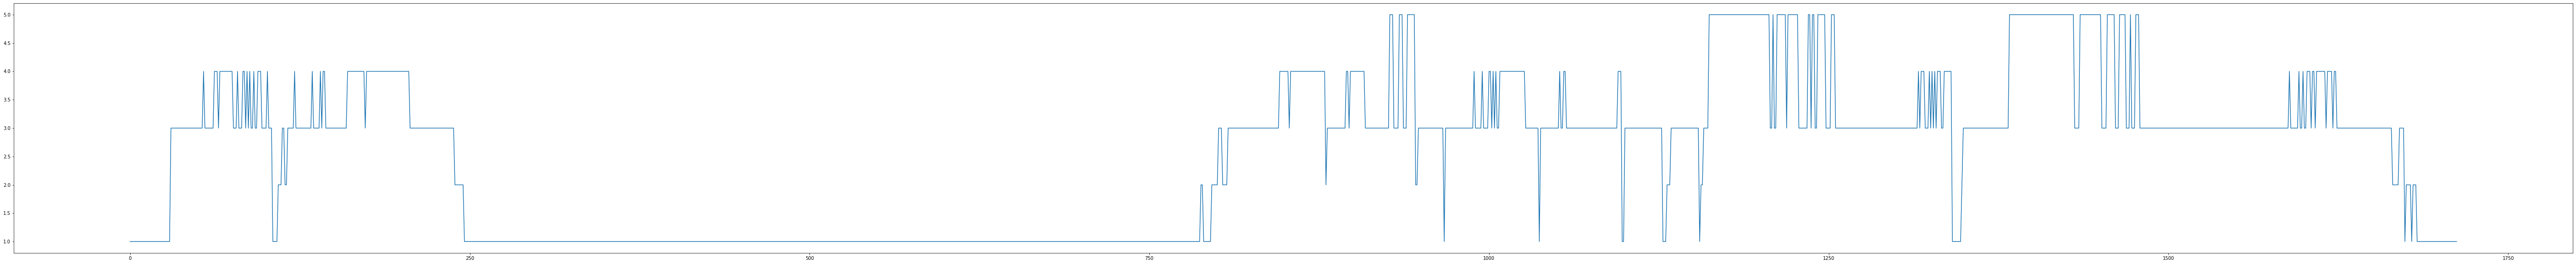

In [ ]:
from matplotlib  import pyplot as plt
fig, ax = plt.subplots(1, 1, figsize = (100, 10))
ax.plot(events_train[:, 2])

In [ ]:
# Read raw and annotation EDF files
    # psg_fnames = glob.glob(os.path.join(args.data_dir, "*PSG.edf"))
    # ann_fnames = glob.glob(os.path.join(args.data_dir, "*Hypnogram.edf"))
    # psg_fnames.sort()
    # ann_fnames.sort()
    # psg_fnames = np.asarray(psg_fnames)
    # ann_fnames = np.asarray(ann_fnames)

    # for i in range(len(psg_fnames)):
    #     # if not "ST7171J0-PSG.edf" in psg_fnames[i]:
    #     #     continue
    #     # i = ii+80
    #     # if i >= len(psg_fnames):
    #     #     break

    #     raw = read_raw_edf(psg_fnames[i], preload=True, stim_channel=None)
    #     sampling_rate = raw.info['sfreq']
    #     raw_ch_df = raw.to_data_frame(scaling_time=100.0)[select_ch]
    #     raw_ch_df = raw_ch_df.to_frame()
    #     raw_ch_df.set_index(np.arange(len(raw_ch_df)))

    #     # # Get raw header
        # f = open(psg_fnames[i], 'r')
        # reader_raw = dhedfreader.BaseEDFReader(f)
        # reader_raw.read_header()
        # h_raw = reader_raw.header
        # f.close()
        # raw_start_dt = datetime.strptime(h_raw['date_time'], "%Y-%m-%d %H:%M:%S")

        # # Read annotation and its header
        # f = open(ann_fnames[i], 'r')
        # reader_ann = dhedfreader.BaseEDFReader(f)
        # reader_ann.read_header()
        # h_ann = reader_ann.header
        # _, _, ann = zip(*reader_ann.records())
        # f.close()
        # ann_start_dt = datetime.strptime(h_ann['date_time'], "%Y-%m-%d %H:%M:%S")

        # # Assert that raw and annotation files start at the same time
        # assert raw_start_dt == ann_start_dt

        # # Generate label and remove indices
        # remove_idx = []    # indicies of the data that will be removed
        # labels = []        # indicies of the data that have labels
        # label_idx = []
        # for a in ann[0]:
        #     onset_sec, duration_sec, ann_char = a
        #     ann_str = "".join(ann_char)
        #     label = ann2label[ann_str]
        #     if label != UNKNOWN:
        #         if duration_sec % EPOCH_SEC_SIZE != 0:
        #             raise Exception("Something wrong")
        #         duration_epoch = int(duration_sec / EPOCH_SEC_SIZE)
        #         label_epoch = np.ones(duration_epoch, dtype=np.int) * label
        #         labels.append(label_epoch)
        #         idx = int(onset_sec * sampling_rate) + np.arange(duration_sec * sampling_rate, dtype=np.int)
        #         label_idx.append(idx)

        #         print ("Include onset:{}, duration:{}, label:{} ({})".format(
        #             onset_sec, duration_sec, label, ann_str
        #         ))
        #     else:
        #         idx = int(onset_sec * sampling_rate) + np.arange(duration_sec * sampling_rate, dtype=np.int)
        #         remove_idx.append(idx)

        #         print ("Remove onset:{}, duration:{}, label:{} ({})".format(
        #             onset_sec, duration_sec, label, ann_str))
        # labels = np.hstack(labels)
        
        # print ("before remove unwanted: {}".format(np.arange(len(raw_ch_df)).shape))
        # if len(remove_idx) > 0:
        #     remove_idx = np.hstack(remove_idx)
        #     select_idx = np.setdiff1d(np.arange(len(raw_ch_df)), remove_idx)
        # else:
        #     select_idx = np.arange(len(raw_ch_df))
        # print ("after remove unwanted: {}".format(select_idx.shape))

        # # Select only the data with labels
        # print ("before intersect label: {}".format(select_idx.shape))
        # label_idx = np.hstack(label_idx)
        # select_idx = np.intersect1d(select_idx, label_idx)
        # print ("after intersect label: {}".format(select_idx.shape))

        # # Remove extra index
        # if len(label_idx) > len(select_idx):
        #     print("before remove extra labels: {}, {}".format(select_idx.shape, labels.shape))
        #     extra_idx = np.setdiff1d(label_idx, select_idx)
        #     # Trim the tail
        #     if np.all(extra_idx > select_idx[-1]):
        #         # n_trims = len(select_idx) % int(EPOCH_SEC_SIZE * sampling_rate)
        #         # n_label_trims = int(math.ceil(n_trims / (EPOCH_SEC_SIZE * sampling_rate)))
        #         n_label_trims = int(math.ceil(len(extra_idx) / (EPOCH_SEC_SIZE * sampling_rate)))
        #         if n_label_trims!=0:
        #             # select_idx = select_idx[:-n_trims]
        #             labels = labels[:-n_label_trims]
        #     print("after remove extra labels: {}, {}".format(select_idx.shape, labels.shape))

        # # Remove movement and unknown stages if any
        # raw_ch = raw_ch_df.values[select_idx]

        # # Verify that we can split into 30-s epochs
        # if len(raw_ch) % (EPOCH_SEC_SIZE * sampling_rate) != 0:
        #     raise Exception("Something wrong")
        # n_epochs = len(raw_ch) / (EPOCH_SEC_SIZE * sampling_rate)

        # # Get epochs and their corresponding labels
        # x = np.asarray(np.split(raw_ch, n_epochs)).astype(np.float32)
        # y = labels.astype(np.int32)

        # assert len(x) == len(y)

        # # Select on sleep periods
        # w_edge_mins = 30
        # nw_idx = np.where(y != stage_dict["W"])[0]
        # start_idx = nw_idx[0] - (w_edge_mins * 2)
        # end_idx = nw_idx[-1] + (w_edge_mins * 2)
        # if start_idx < 0: start_idx = 0
        # if end_idx >= len(y): end_idx = len(y) - 1
        # select_idx = np.arange(start_idx, end_idx+1)
        # print("Data before selection: {}, {}".format(x.shape, y.shape))
        # x = x[select_idx]
        # y = y[select_idx]
        # print("Data after selection: {}, {}".format(x.shape, y.shape))

        # # Save
        # filename = ntpath.basename(psg_fnames[i]).replace("-PSG.edf", ".npz")
        # save_dict = {
        #     "x": x, 
        #     "y": y, 
        #     "fs": sampling_rate,
        #     "ch_label": select_ch,
        #     "header_raw": h_raw,
        #     "header_annotation": h_ann,
        # }
        # np.savez(os.path.join(args.output_dir, filename), **save_dict)

        # print ("\n=======================================\n")
